In [ ]:
import pandas as pd
import numpy as np
import datetime
import time
import math
import datetime
import lightgbm
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# **I - Import Data**

In [ ]:
%%time
df = pd.read_csv('CAX_LogFacies_Train_File.csv')

CPU times: user 1.24 s, sys: 243 ms, total: 1.49 s
Wall time: 1.5 s


In [ ]:
print("Shape df : ", df.shape)
df.head()

Shape df :  (4400000, 4)


,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


# **II - Data Preprocessing**

### *1 - Add Shift features*

In [ ]:
%%time
nb_shift = 51

def addPreviousShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(k)] = data[feat_shifted].shift(k)
    return 

def addFuturShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(-k)] = data[feat_shifted].shift(-k)
    return

addPreviousShift(data=df, feat_shifted='GR', n_shift=nb_shift, step=1)
addFuturShift(data=df, feat_shifted='GR', n_shift=nb_shift, step=1)

CPU times: user 2.38 s, sys: 4.25 s, total: 6.63 s
Wall time: 6.64 s


### *2 - NaN & Standardization*

In [ ]:
%%time
def dropNaN(data, n_shift):
    data = data.drop([elem for elem in range(0,nb_shift,1)])
    data = data.drop([elem for elem in data.tail(nb_shift).index])
    data = data.reset_index(drop=True)
    return data

df = dropNaN(data=df, n_shift=nb_shift)

features = [col for col in df.columns if col not in ['row_id', 'well_id', 'label']]
target = 'label'

# standardization in (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
df[features] = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

CPU times: user 10.2 s, sys: 1.44 s, total: 11.6 s
Wall time: 11.6 s


In [ ]:
df.head()

,row_id,well_id,GR,label,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24,shift_25,shift_26,shift_27,shift_28,shift_29,shift_30,shift_31,shift_32,shift_33,shift_34,shift_35,shift_36,shift_37,shift_38,shift_39,shift_40,shift_41,shift_42,shift_43,shift_44,shift_45,shift_46,shift_47,shift_48,shift_49,shift_50,shift_-1,shift_-2,shift_-3,shift_-4,shift_-5,shift_-6,shift_-7,shift_-8,shift_-9,shift_-10,shift_-11,shift_-12,shift_-13,shift_-14,shift_-15,shift_-16,shift_-17,shift_-18,shift_-19,shift_-20,shift_-21,shift_-22,shift_-23,shift_-24,shift_-25,shift_-26,shift_-27,shift_-28,shift_-29,shift_-30,shift_-31,shift_-32,shift_-33,shift_-34,shift_-35,shift_-36,shift_-37,shift_-38,shift_-39,shift_-40,shift_-41,shift_-42,shift_-43,shift_-44,shift_-45,shift_-46,shift_-47,shift_-48,shift_-49,shift_-50
0,51,0,0.148196,0,0.143991,0.211899,0.447204,0.139469,0.217864,0.229541,0.176296,0.353871,0.371340,0.375426,0.236586,0.343846,0.132294,0.239055,0.180217,0.172517,0.321727,0.219042,0.261182,0.198748,-0.002416,0.185146,0.189432,0.175040,0.411343,0.297073,0.224552,0.161819,0.126353,0.065018,0.237200,0.237090,0.179451,-0.029803,0.189920,0.230561,0.372779,0.075531,0.305742,0.262086,0.317609,0.357451,0.224204,0.172558,0.261740,0.234464,0.266415,0.147351,0.265598,0.158319,0.314602,0.263174,0.007095,0.463449,0.114783,0.232249,0.116499,0.178133,0.141987,0.108037,0.404086,0.408990,0.287447,0.194769,0.328316,0.157932,0.302965,0.204794,0.346930,0.171353,0.165969,0.242485,0.194153,0.174187,0.126953,0.194481,0.283681,0.236348,0.441408,0.195117,0.192130,0.304203,0.199340,0.385522,0.295042,0.168105,0.326622,0.215366,0.121790,0.303977,0.090346,0.205316,0.281932,0.197344,0.297332,0.204854,0.449166,0.083120,0.139061,0.122790
1,52,0,0.314602,0,0.148196,0.143991,0.211899,0.447204,0.139469,0.217864,0.229541,0.176296,0.353871,0.371340,0.375426,0.236586,0.343846,0.132294,0.239055,0.180217,0.172517,0.321727,0.219042,0.261182,0.198748,-0.002416,0.185146,0.189432,0.175040,0.411343,0.297073,0.224552,0.161819,0.126353,0.065018,0.237200,0.237090,0.179451,-0.029803,0.189920,0.230561,0.372779,0.075531,0.305742,0.262086,0.317609,0.357451,0.224204,0.172558,0.261740,0.234464,0.266415,0.147351,0.265598,0.263174,0.007095,0.463449,0.114783,0.232249,0.116499,0.178133,0.141987,0.108037,0.404086,0.408990,0.287447,0.194769,0.328316,0.157932,0.302965,0.204794,0.346930,0.171353,0.165969,0.242485,0.194153,0.174187,0.126953,0.194481,0.283681,0.236348,0.441408,0.195117,0.192130,0.304203,0.199340,0.385522,0.295042,0.168105,0.326622,0.215366,0.121790,0.303977,0.090346,0.205316,0.281932,0.197344,0.297332,0.204854,0.449166,0.083120,0.139061,0.122790,0.066468
2,53,0,0.263174,0,0.314602,0.148196,0.143991,0.211899,0.447204,0.139469,0.217864,0.229541,0.176296,0.353871,0.371340,0.375426,0.236586,0.343846,0.132294,0.239055,0.180217,0.172517,0.321727,0.219042,0.261182,0.198748,-0.002416,0.185146,0.189432,0.175040,0.411343,0.297073,0.224552,0.161819,0.126353,0.065018,0.237200,0.237090,0.179451,-0.029803,0.189920,0.230561,0.372779,0.075531,0.305742,0.262086,0.317609,0.357451,0.224204,0.172558,0.261740,0.234464,0.266415,0.147351,0.007095,0.463449,0.114783,0.232249,0.116499,0.178133,0.141987,0.108037,0.404086,0.408990,0.287447,0.194769,0.328316,0.157932,0.302965,0.204794,0.346930,0.171353,0.165969,0.242485,0.194153,0.174187,0.126953,0.194481,0.283681,0.236348,0.441408,0.195117,0.192130,0.304203,0.199340,0.385522,0.295042,0.168105,0.326622,0.215366,0.121790,0.303977,0.090346,0.205316,0.281932,0.197344,0.297332,0.204854,0.449166,0.083120,0.139061,0.122790,0.066468,0.239767
3,54,0,0.007095,0,0.263174,0.314602,0.148196,0.143991,0.211899,0.447204,0.139469,0.217864,0.229541,0.176296,0.353871,0.371340,0.375426,0.236586,0.343846,0.132294,0.239055,0.180217,0.172517,0.321727,0.219042,0.261182,0.198748,-0.002416,0.185146,0.189432,0.175040,0.411343,0.297073,0.2

# **III - Machine Learning**

### *1 - Evaluation function*

In [ ]:
def acc_eval(preds, train_data):
    """ Accuracy evaluation function"""
    n_labels = 5
    y_true = train_data.get_label()
    reshaped_preds = preds.reshape(n_labels, -1)
    y_pred = np.argmax(reshaped_preds, axis=0)
    acc = accuracy_score(y_true, y_pred)
    return 'accuracy', acc, True

### *2 - Built model*

##### 2.a - Parameters

In [ ]:
param_classifieur = {'boosting_type': 'gbdt',
                     'colsample_bytree': 1,
                     'learning_rate':.2,
                     'max_depth': 5,
                     'verbose':10,
                     'n_jobs': 4,
                     'num_leaves': 30,
                     'objective': 'multiclass',
                     'num_class':5,
                     'random_state': None,
                     'reg_alpha': 0,
                     'reg_lambda': 0,
                     'subsample_for_bin': 1100,
                     'max_bin':30,
                     'metric':'None',
                     'boost_from_average':True, #IMPORTANT !
                     'use_missing':True,
                     'is_unbalance' :True}

##### 2.b - Training

In [ ]:
num_model = 3

print("Start creation of Model number : " +str(num_model))

#Keep index
print("Find index...")
well_id_train = []
well_id_validation = []
well_id_validation = [ind for ind in range(500*(num_model-1), 500*num_model, 1)]
well_id_train = [ind for ind in range(0, 4000, 1) if ind not in well_id_validation]
ind_train = df.index[(df.well_id >= min(well_id_train))&(df.well_id <= max(well_id_train))]
ind_validation = df.index[(df.well_id >= min(well_id_validation))&(df.well_id <= max(well_id_validation))]

print("Segmentation...")
#Segmentation
x_train = pd.DataFrame(df.loc[ind_train, features], columns = features)
y_train = pd.DataFrame(df.loc[ind_train, target], columns=[target])
x_validation = pd.DataFrame(df.loc[ind_validation, features], columns = features)
y_validation = pd.DataFrame(df.loc[ind_validation, target], columns = [target])

# #Create LightGBM Dataset
# lgb_train = lightgbm.Dataset(x_train.values, y_train  .values.ravel())
# lgb_validation   = lightgbm.Dataset(x_validation.values, y_validation.values.ravel())

# print("Start training model : " +str(num_model)+ ' ...')
# #Training
# evals_results={}
# model = lightgbm.train(params=param_classifieur, 
#                         train_set=lgb_train,
#                         valid_sets=[lgb_validation], 
#                         valid_names=['Validation'],
#                         evals_result=evals_results,
#                         feval=acc_eval,
#                         num_boost_round=5000,
#                         early_stopping_rounds=10)
    
# print("End training -> save model")
# model.save_model('model_'+str(num_model), num_iteration=model.best_iteration)

Start creation of Model number : 3
Find index...
Segmentation...


# **IV - Prediction**

### *1 - Predict*

In [ ]:
%%time
model = lightgbm.Booster(model_file='model_3')

prediction_train = pd.DataFrame(model.predict(x_train), columns=['Proba_'+str(i) for i in range(0,5,1)],
                                index=x_train.index)
prediction_validation = pd.DataFrame(model.predict(x_validation), columns=['Proba_'+str(i) for i in range(0,5,1)],
                                     index=x_validation.index)

def convertProbaToInteger(prediction):
    return np.argmax(prediction.T.values, axis=0)

int_pred_train = pd.DataFrame(prediction_train.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                              index=x_train.index)
int_pred_val = pd.DataFrame(prediction_validation.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                            index=x_validation.index)

CPU times: user 3h 17min, sys: 4.7 s, total: 3h 17min 5s
Wall time: 50min


In [ ]:
%%time
# If Load from extern 
prediction_train = pd.read_csv('p_train.csv', usecols=['Proba_0', 'Proba_1', 'Proba_2', 'Proba_3', 'Proba_4'])
prediction_validation = pd.read_csv('p_val.csv', usecols=['Proba_0', 'Proba_1', 'Proba_2', 'Proba_3', 'Proba_4'])
prediction_validation.index = x_validation.index

def convertProbaToInteger(prediction):
    return np.argmax(prediction.T.values, axis=0)

int_pred_train = pd.DataFrame(prediction_train.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                              index=x_train.index)
int_pred_val = pd.DataFrame(prediction_validation.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                            index=x_validation.index)

CPU times: user 43.3 s, sys: 335 ms, total: 43.6 s
Wall time: 43.6 s


# **V - Evaluation**

### *1 - Confusion matrix*

In [ ]:
print('\nModel:')
print('train accuracy :', round(accuracy_score(y_true=y_train, y_pred=int_pred_train), 3))
print('validation accuracy :', round(accuracy_score(y_true=y_validation, y_pred=int_pred_val), 3))


Model:
train accuracy : 0.959
validation accuracy : 0.959


Model
******************************* Train

         Pred 0  Pred 1  Pred 2  Pred 3  Pred 4
True 0  2281720    6177      18   11830   13434
True 1     9950  481257    8772   12619    8146
True 2       30    8558  507641    4436    4711
True 3    22866   16408    5049  474192    3625
True 4    23786    9636    5892    3438  475707


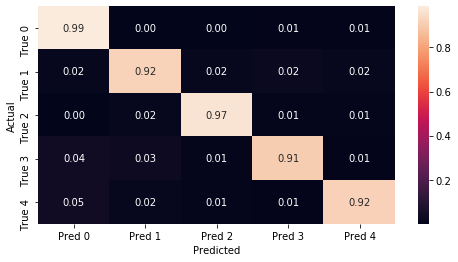

******************************* Validation

        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4
True 0  284124     842       3    1532    1843
True 1    1141   60961    1239    1379    1048
True 2       6    1129   61892     658     563
True 3    2501    2019     751   60399     558
True 4    3055    1117     717     443   60080


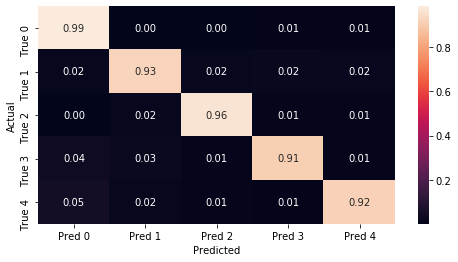

In [ ]:
# attention : le taux signifie le ratio de label trouvé sur le total existant
def plotConfusionMatrix(y_true, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_true, y_pred), index=['True '+str(i) for i in range(5)],
                        columns = ['Pred '+str(j) for j in range(5)])
    print(conf)
    
    # Normalise
    cmn = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=conf.columns, yticklabels=conf.index)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return

print('Model')
print('******************************* Train\n')
plotConfusionMatrix(y_true=y_train, y_pred=int_pred_train)
print('******************************* Validation\n')
plotConfusionMatrix(y_true=y_validation, y_pred=int_pred_val)

#### *2 - Prediction analysis*

In [ ]:
%%time
def createErrorArray(y_true, y_pred, data_well_id):
    tab = pd.concat([y_true.reset_index(drop=True), pd.DataFrame(y_pred)], axis=1)
    tab.columns = ['True', 'Pred']
    tab['error'] = tab[['True', 'Pred']].apply(lambda x: 1 if x['True']!=x['Pred'] else 0, axis=1)
    ArrayError = tab[tab['error'] == 1]
    ArrayError.loc[ArrayError.index, 'well_id'] = data_well_id.loc[ArrayError.index].values
    return ArrayError

errTrain = createErrorArray(y_train, int_pred_train, data_well_id = df['well_id'])
errValidation = createErrorArray(y_validation, int_pred_val, data_well_id = df['well_id']) 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 1min 57s, sys: 39.1 ms, total: 1min 57s
Wall time: 1min 57s


       # Labels    Color Label_Description
Label                                     
0           493     dark              None
2           238      red       Cylindrical
3           204     blue            Funnel
4           118    green              Bell
1            47  magenta       Symmetrical


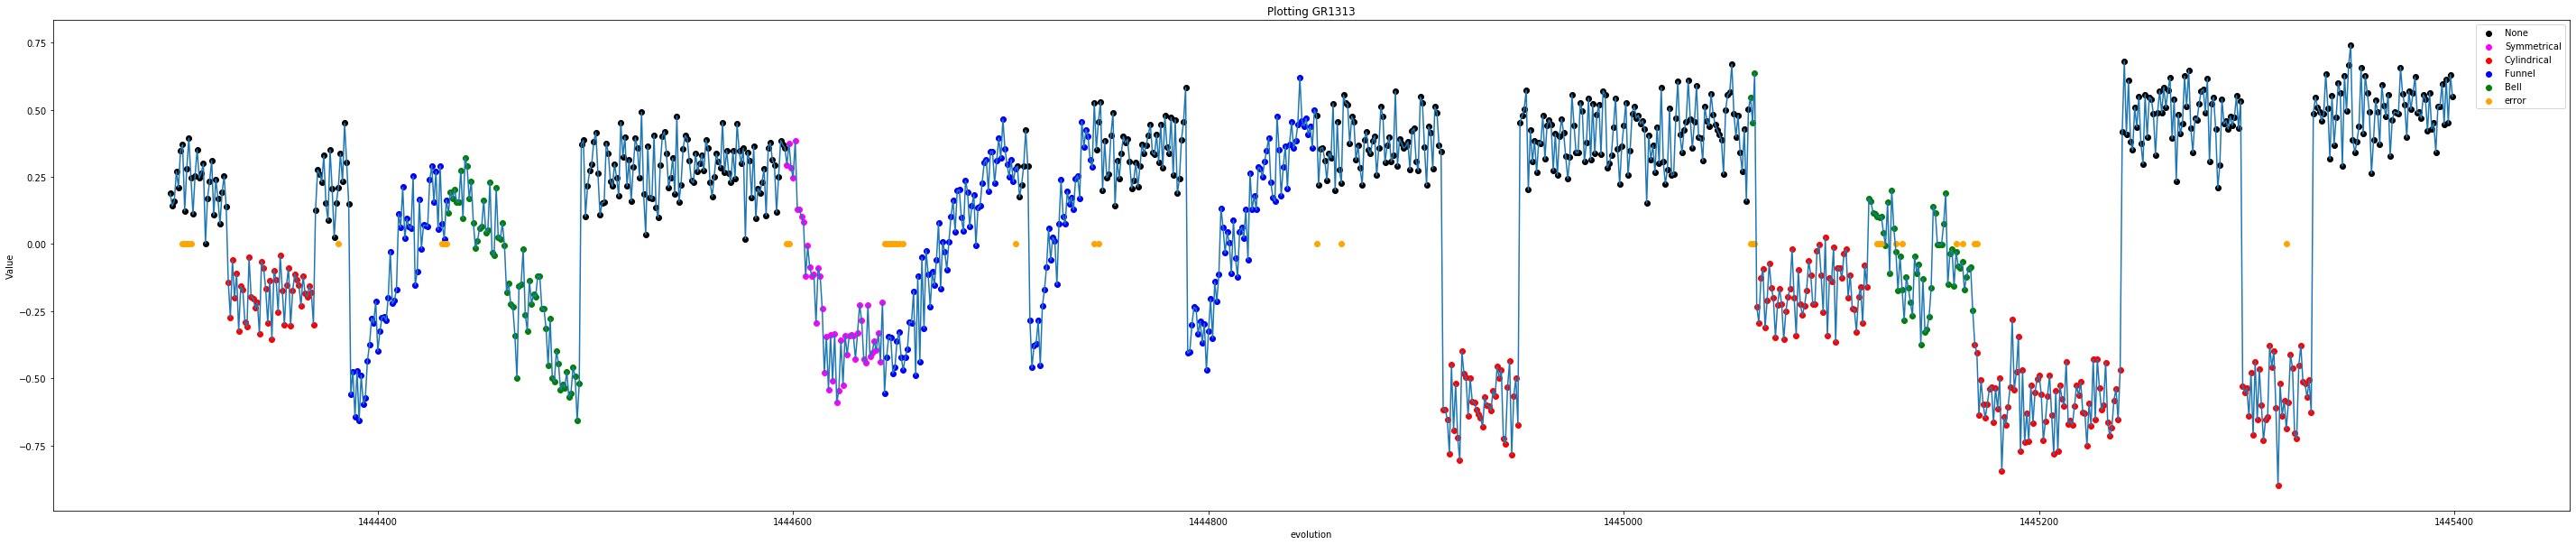

In [ ]:
def findColor(label):
    if label.name==0:
        return 'dark'
    elif label.name==1:
        return 'magenta'
    elif label.name==2:
        return 'red'
    elif label.name==3:
        return 'blue'
    elif label.name==4:
        return 'green'
    else:
        return 'error'
    
def DescriptLabel(label):
    if label.name==0:
        return 'None'
    elif label.name==1:
        return 'Symmetrical'
    elif label.name==2:
        return 'Cylindrical'
    elif label.name==3:
        return 'Funnel'
    elif label.name==4:
        return 'Bell'
    else:
        return 'error'

def plotErr(data, errArray, well_id, yPos=50, zoom=None):
    
    sstab = errArray[errArray.well_id == well_id]
    ech = data[['GR', 'label']][data.well_id == well_id]
    
    if zoom:
        plt.figure(figsize=(50,10))
    else:
        plt.figure(figsize=(20,8))    
    plt.plot(ech['GR'])
    
    try:
        plt.scatter(x=ech[ech['label'] == 0].index.to_list(), y=ech['GR'][ech['label'] == 0].values, c='black',
                   label='None')
    except:
        pass
    try:
        plt.scatter(x=ech[ech['label'] == 1].index, y=ech['GR'][ech['label'] == 1], c='magenta', 
                    label='Symmetrical')
    except:
        pass
    try:
        plt.scatter(x=ech[ech['label'] == 2].index, y=ech['GR'][ech['label'] == 2], c='red', 
                    label='Cylindrical')
    except:
        pass
    try:
        plt.scatter(x=ech[ech['label'] == 3].index, y=ech['GR'][ech['label'] == 3], c='blue', 
                    label='Funnel')
    except:
        pass
    try:
        plt.scatter(x=ech[ech['label'] == 4].index, y=ech['GR'][ech['label'] == 4], c='green', 
                    label='Bell')
    except:
        pass
    
    plt.scatter(x=sstab.index, y=[yPos]*len(sstab.index), c='orange', label='error')
        
    plt.ylabel('Value')
    plt.xlabel('evolution')
    plt.title('Plotting GR'+str(well_id))
    plt.legend()

    lab = pd.DataFrame(data['label'][data.well_id == well_id].value_counts())
    lab.columns = ['# Labels']
    lab['Color'] = lab.T.apply(findColor)
    lab['Label_Description'] = lab.T.apply(DescriptLabel)
    lab.index.name = 'Label'
    
    print(lab)
    return 

well_id_error = errValidation['well_id'].unique().tolist()
plotErr(data=df, errArray=errValidation, well_id=random.choice(well_id_error), yPos=0, zoom='None') 

### *3 - Probability analysis*

In [ ]:
def createErrorArray2(y_true, y_pred, proba, new_index, data_well_id):
    tab = pd.concat([y_true.reset_index(drop=True), y_pred, pd.DataFrame(proba)], axis=1)
    tab.columns = ['True', 'Pred']+['Proba_'+str(col) for col in proba.columns]
    tab.index = new_index
    tab['error'] = tab[['True', 'Pred']].apply(lambda x: 1 if x['True']!=x['Pred'] else 0, axis=1)
#     ArrayError = tab[tab['error'] == 1]
#     ArrayError.loc[ArrayError.index, 'well_id'] = data_well_id.loc[ArrayError.index].values
    return tab

# errProbTrain = createErrorArray2(y_train, int_pred_train, new_index=x_train.index, data_well_id = df['well_id'])
errProbValidation = createErrorArray2(y_true=y_validation, y_pred=int_pred_val, proba=prediction_validation, new_index=x_validation.index, data_well_id = df['well_id']) 
# errProbTest = createErrorArray2(y_test, int_pred_test, new_index=x_test.index, data_well_id = df['well_id']) 

In [ ]:
errProbValidation.head()

,True,Pred,Proba_0,Proba_1,Proba_2,Proba_3,Proba_4,error
386100,0,0,0.996460,0.000787,1.248920e-08,0.001430,0.001324,0
386101,0,0,0.991410,0.000402,1.196806e-08,0.008102,0.000086,0
386102,0,0,0.988419,0.000865,8.337776e-08,0.004699,0.006016,0
386103,0,0,0.990809,0.000963,2.458161e-08,0.001575,0.006653,0
386104,0,0,0.990190,0.001271,9.177518e-09,0.000472,0.008066,0


In [ ]:
tab00 = errProbValidation[(errProbValidation.Pred == 0)&(errProbValidation.error == 0)]
tab01 = errProbValidation[(errProbValidation.Pred == 0)&(errProbValidation.error == 1)]

In [ ]:
tab00.describe()

,True,Pred,Proba_0,Proba_1,Proba_2,Proba_3,Proba_4,error
count,56576.0,56576.0,56576.000000,5.657600e+04,5.657600e+04,5.657600e+04,5.657600e+04,56576.0
mean,0.0,0.0,0.971090,5.682273e-03,1.508973e-06,1.178265e-02,1.144330e-02,0.0
std,0.0,0.0,0.074266,2.831705e-02,8.950401e-05,4.330315e-02,4.183407e-02,0.0
min,0.0,0.0,0.330083,2.433674e-09,2.441483e-13,4.084137e-08,3.794540e-08,0.0
25%,0.0,0.0,0.984871,6.732690e-05,3.512400e-09,2.691515e-04,3.575553e-04,0.0
50%,0.0,0.0,0.996723,1.904274e-04,9.018610e-09,8.543276e-04,1.006760e-03,0.0
75%,0.0,0.0,0.998988,8.186105e-04,3.168953e-08,3.656949e-03,3.856749e-03,0.0
max,0.0,0.0,1.000000,4.878887e-01,1.952773e-02,4.971129e-01,4.967274e-01,0.0


In [ ]:
tab01.describe()

,True,Pred,Proba_0,Proba_1,Proba_2,Proba_3,Proba_4,error
count,2889.000000,2889.0,2889.000000,2.889000e+03,2.889000e+03,2889.000000,2889.000000,2889.0
mean,3.012115,0.0,0.735861,5.763876e-02,8.611536e-06,0.105078,0.101414,1.0
std,1.081284,0.0,0.169396,1.018598e-01,1.335250e-04,0.137142,0.140260,0.0
min,1.000000,0.0,0.293475,4.463793e-07,1.449329e-11,0.000003,0.000008,1.0
25%,3.000000,0.0,0.591156,1.041763e-03,3.473581e-08,0.002256,0.002863,1.0
50%,3.000000,0.0,0.739852,6.541397e-03,1.201972e-07,0.030284,0.021573,1.0
75%,4.000000,0.0,0.890789,5.928959e-02,4.080669e-07,0.177763,0.162801,1.0
max,4.000000,0.0,0.999476,4.768939e-01,4.977934e-03,0.495927,0.494804,1.0


### *4 - Features importances*

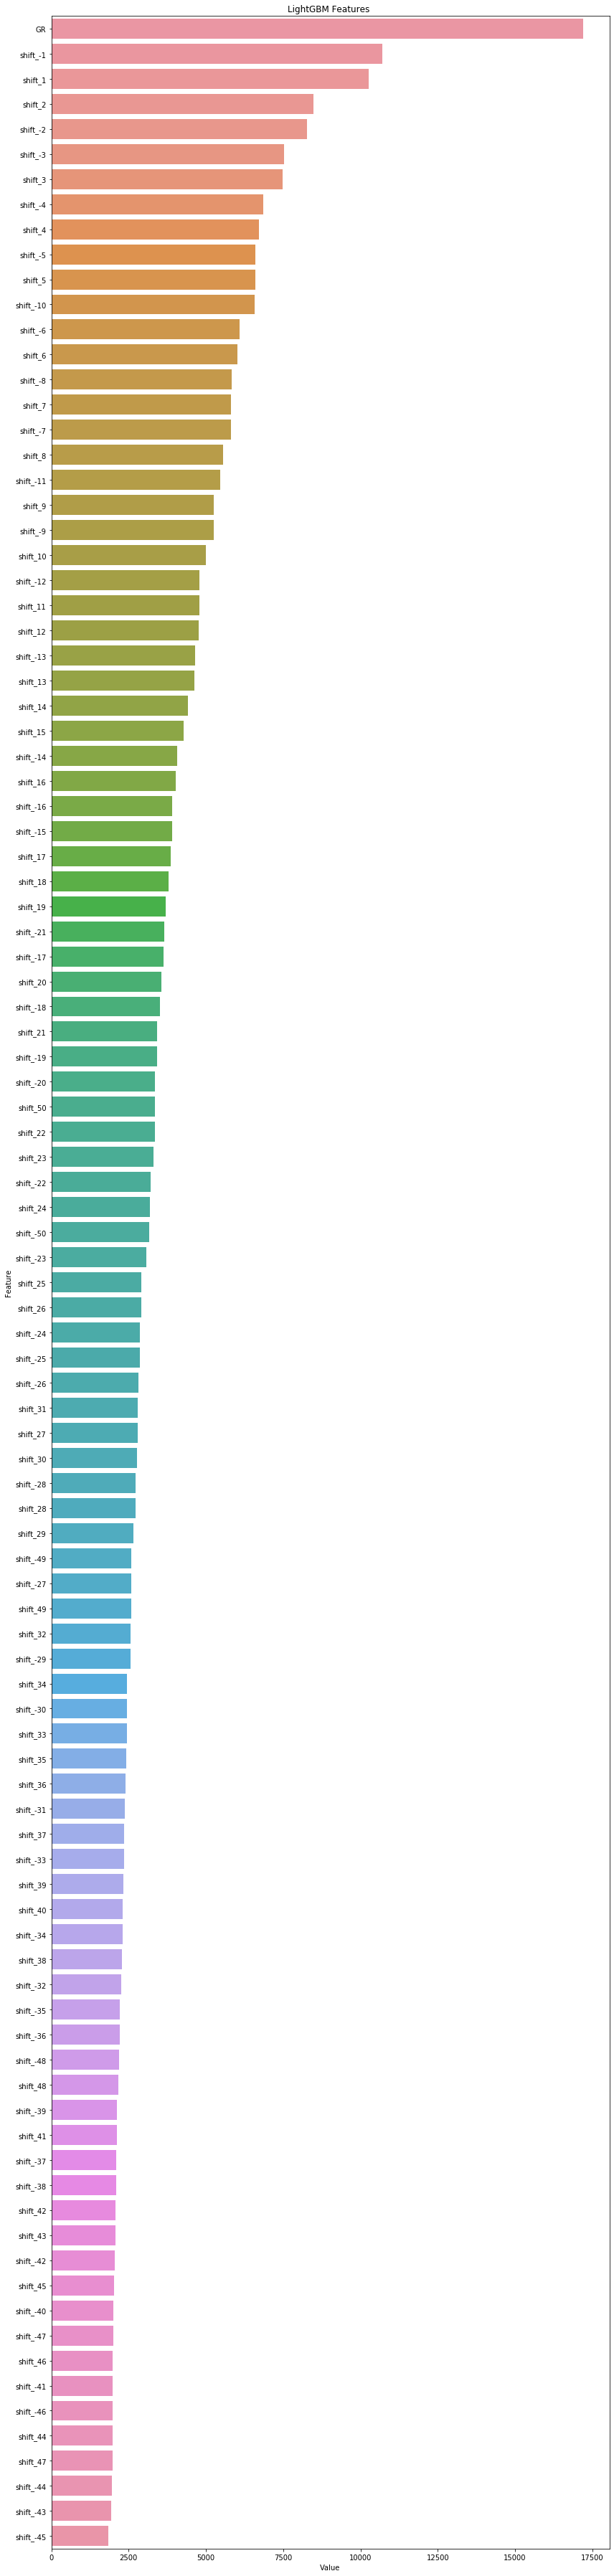

CPU times: user 2.25 s, sys: 363 ms, total: 2.62 s
Wall time: 2.28 s


In [ ]:
%%time
base = x_validation
sorted(zip(model.feature_importance(), base.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), base.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 50))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features ')
plt.tight_layout()
plt.show()

# **VI - Score Improvment**

### *1 - Second model*

##### 1.a - Segmentation

In [ ]:
%%time
pred_train = int_pred_train.copy()
pred_val = int_pred_val.copy()

def addPreviousShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(k)] = data[feat_shifted].shift(k)
    return 

def addFuturShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(-k)] = data[feat_shifted].shift(-k)
    return

#Shift train prediction
addPreviousShift(data=pred_train, feat_shifted='Prediction', n_shift=51, step=1)
addFuturShift(data=pred_train, feat_shifted='Prediction', n_shift=51, step=1)

#Shift validation prediction
addPreviousShift(data=pred_val, feat_shifted='Prediction', n_shift=51, step=1)
addFuturShift(data=pred_val, feat_shifted='Prediction', n_shift=51, step=1)

features_model_2 = [col for col in pred_train.columns]

#Filling NaN
pred_train[features_model_2] = pred_train[features_model_2].fillna(method='bfill')
pred_val[features_model_2] = pred_val[features_model_2].fillna(method='bfill')

#Modif format to categorical
for col in pred_train.columns:
    pred_train[col] = pred_train[col].astype('category')
    pred_train[col] = pd.Categorical(pred_train[col].cat.codes)
    pred_train[col] = pred_train[col].astype(np.int64)

for col in pred_val.columns:
    pred_val[col] = pred_val[col].astype('category')
    pred_val[col] = pd.Categorical(pred_val[col].cat.codes)
    pred_val[col] = pred_val[col].astype(np.int64)

#Create LightGBM Dataset
lgb_train_2 = lightgbm.Dataset(pred_train.values, y_train.values.ravel())
lgb_validation_2 = lightgbm.Dataset(pred_val.values, y_validation.values.ravel())

CPU times: user 1min 7s, sys: 5.85 s, total: 1min 12s
Wall time: 1min 12s


In [ ]:
# using LightGBM on sklearn API 
from lightgbm import LGBMClassifier

def acc_eval_sklearn(preds, train_data):
    """ Accuracy evaluation function for LightGBM sklearn API """
    n_labels = 5
    y_pred = preds
    reshaped_train = train_data.reshape(n_labels, -1)
    y_true = np.argmax(reshaped_train, axis=0)
    acc = accuracy_score(y_true, y_pred)
    return 'accuracy', acc, True

class_w = {0:.3, 1:.25, 2:.1, 3:.25, 4:.1}

second_model = LGBMClassifier(boosting_type='gbdt',
                              num_leaves=30,
                              max_depth=-1,
                              learning_rate=0.2,
                              n_estimators=1500,
                              subsample_for_bin=200000,
                              objective='multiclass',
                              class_weight=class_w,
                              min_split_gain=0.0,
                              min_child_weight=0.001,
                              min_child_samples=20,
                              subsample=1.0,
                              subsample_freq=0,
                              colsample_bytree=1.0,
                              reg_alpha=0.0,
                              reg_lambda=0.0,
                              random_state=None,
                              n_jobs=-1,
                              silent=True,
                              importance_type='split')



second_model = second_model.fit(X=pred_train.values,
                 y=y_train.values.ravel(),
                 sample_weight=None,
                 init_score=None,
                 eval_set=(pred_val.values, y_validation.values.ravel()),
                 eval_names=['Validation'],
                 eval_sample_weight=None,
                 eval_class_weight=None,
                 eval_init_score=None,
                 eval_metric=acc_eval_sklearn,
                 early_stopping_rounds=50,
                 verbose=True,
                 feature_name=features_model_2,
                 categorical_feature=features_model_2,
                 callbacks=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Prediction', 'shift_-1', 'shift_-10', 'shift_-11', 'shift_-12', 'shift_-13', 'shift_-14', 'shift_-15', 'shift_-16', 'shift_-17', 'shift_-18', 'shift_-19', 'shift_-2', 'shift_-20', 'shift_-21', 'shift_-22', 'shift_-23', 'shift_-24', 'shift_-25', 'shift_-26', 'shift_-27', 'shift_-28', 'shift_-29', 'shift_-3', 'shift_-30', 'shift_-31', 'shift_-32', 'shift_-33', 'shift_-34', 'shift_-35', 'shift_-36', 'shift_-37', 'shift_-38', 'shift_-39', 'shift_-4', 'shift_-40', 'shift_-41', 'shift_-42', 'shift_-43', 'shift_-44', 'shift_-45', 'shift_-46', 'shift_-47', 'shift_-48', 'shift_-49', 'shift_-5', 'shift_-50', 'shift_-6', 'shift_-7', 'shift_-8', 'shift_-9', 'shift_1', 'shift_10', 'shift_11', 'shift_12', 'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18', 'shift_19', 'shift_2', 'shift_20', 'shift_21', 'shift_22', 'shift_23', 'shif

[1]	Validation's multi_logloss: 0.820385	Validation's accuracy: 0.524262
Training until validation scores don't improve for 50 rounds.
[2]	Validation's multi_logloss: 0.647293	Validation's accuracy: 0.723155
[3]	Validation's multi_logloss: 0.530878	Validation's accuracy: 0.937538
[4]	Validation's multi_logloss: 0.446068	Validation's accuracy: 0.949249
[5]	Validation's multi_logloss: 0.382184	Validation's accuracy: 0.956625
[6]	Validation's multi_logloss: 0.332937	Validation's accuracy: 0.95856
[7]	Validation's multi_logloss: 0.294342	Validation's accuracy: 0.959553
[8]	Validation's multi_logloss: 0.263885	Validation's accuracy: 0.960087
[9]	Validation's multi_logloss: 0.239681	Validation's accuracy: 0.960344
[10]	Validation's multi_logloss: 0.220321	Validation's accuracy: 0.960484
[11]	Validation's multi_logloss: 0.204809	Validation's accuracy: 0.960742
[12]	Validation's multi_logloss: 0.192337	Validation's accuracy: 0.960893
[13]	Validation's multi_logloss: 0.182275	Validation's accur

In [ ]:
second_model.booster_.save_model('model_Second')

In [ ]:
# %%time
model = lightgbm.Booster(model_file='model_Second_deep')

prediction_train2 = pd.DataFrame(model.predict(pred_train),
                                 columns=['Proba_'+str(i) for i in range(0,5,1)], index=pred_train.index)
prediction_validation2 = pd.DataFrame(model.predict(pred_val),
                                      columns=['Proba_'+str(i) for i in range(0,5,1)], index=pred_val.index)

def convertProbaToInteger(prediction):
    return np.argmax(prediction.T.values, axis=0)

int_pred_train2 = pd.DataFrame(prediction_train2.apply(convertProbaToInteger, axis=1),
                               columns=['Prediction'],index=pred_train.index)
int_pred_val2 = pd.DataFrame(prediction_validation2.apply(convertProbaToInteger, axis=1), 
                             columns=['Prediction'], index=pred_val.index)

In [ ]:
print('\nModel:')
print('train accuracy :', round(accuracy_score(y_true=y_train, y_pred=int_pred_train2), 3))
print('validation accuracy :', round(accuracy_score(y_true=y_validation, y_pred=int_pred_val2), 3))


Model:
train accuracy : 0.984
validation accuracy : 0.985


##### 1.b - Training

In [ ]:
param_classifieur_2 = {'boosting_type': 'gbdt',
                     'colsample_bytree': 1,
                     'learning_rate':.05,
                     'max_depth': 2,
                     'verbose':10,
                     'n_jobs': 4,
                     'num_leaves': 300,
                     'objective': 'multiclass',
                     'num_class':5,
                     'random_state': None,
                     'reg_alpha': 0,
                     'reg_lambda': 0,
                     'subsample_for_bin': 11000,
                     'max_bin':300,
                     'metric':'None',
                     'boost_from_average':False #IMPORTANT !
                     }



evals_results_2={}
model_2 = lightgbm.train(params=param_classifieur_2  , 
                        train_set=lgb_train_2 ,
                        valid_sets=[lgb_validation_2], 
                        valid_names=['Validation'],
                        evals_result=evals_results_2,
                        feval=acc_eval,
                        num_boost_round=5000,
                        early_stopping_rounds=30)
    
print("End training -> save model")
# model_2.save_model('model_2', num_iteration=model_2.best_iteration)

[1]	Validation's accuracy: 0.959011
Training until validation scores don't improve for 30 rounds.
[2]	Validation's accuracy: 0.959011
[3]	Validation's accuracy: 0.959011
[4]	Validation's accuracy: 0.959011
[5]	Validation's accuracy: 0.959011
[6]	Validation's accuracy: 0.959011
[7]	Validation's accuracy: 0.959011
[8]	Validation's accuracy: 0.959011


KeyboardInterrupt: ignored

# Submission

##### Import

In [ ]:
Test = pd.read_csv('CAX_LogFacies_Test_File.csv')
sub = pd.read_csv('CAX_LogFacies_Submission_File.csv')

In [ ]:
print(Test.shape)
Test.head()

(2200000, 4)


,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


##### Preprocessing

In [ ]:
%%time
def addPreviousShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(k)] = data[feat_shifted].shift(k)
    return 

def addFuturShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(-k)] = data[feat_shifted].shift(-k)
    return

addPreviousShift(data=Test, feat_shifted='GR', n_shift=51, step=1)
addFuturShift(data=Test, feat_shifted='GR', n_shift=51, step=1)

features_test = [col for col in df.columns if col not in ['unique_id', 'row_id', 'well_id', 'label']]
target = 'label'

Test[features_test] = Test[features_test].fillna(method='bfill')
Test[features_test] = Test[features_test].fillna(method='ffill')

Test[features_test] = pd.DataFrame(scaler.transform(Test[features_test]), columns=features_test)

CPU times: user 12.2 s, sys: 5.03 s, total: 17.2 s
Wall time: 17.3 s


##### Prediction

In [ ]:
%%time
# Load first model
model = lightgbm.Booster(model_file='model_3')

# Predict proba
prediction = pd.DataFrame(model.predict(Test[features_test]),
                          columns=['Proba_'+str(i) for i in range(0,5,1)], index=Test.index)

def convertProbaToInteger(prediction):
    return np.argmax(prediction.T.values, axis=0)

#Convert to binary 
int_prediction =  pd.DataFrame(prediction.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                               index=Test.index)

CPU times: user 54min 1s, sys: 3.66 s, total: 54min 5s
Wall time: 13min 54s


### Prediction with second model

##### Segmentation

In [ ]:
# %%time
pred = int_prediction.copy()

def addPreviousShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(k)] = data[feat_shifted].shift(k)
    return 

def addFuturShift(data, feat_shifted, n_shift, step):
    for k in range(1, n_shift, step):
        data['shift_'+str(-k)] = data[feat_shifted].shift(-k)
    return

#Shift train prediction
addPreviousShift(data=pred, feat_shifted='Prediction', n_shift=51, step=1)
addFuturShift(data=pred, feat_shifted='Prediction', n_shift=51, step=1)

features_model_2_test = [col for col in pred.columns]

#Filling NaN
pred[features_model_2_test] = pred[features_model_2_test].fillna(method='bfill')
pred[features_model_2_test] = pred[features_model_2_test].fillna(method='ffill')

for col in pred.columns:
    pred[col] = pred[col].astype('category')
    pred[col] = pd.Categorical(pred[col].cat.codes)
    pred[col] = pred[col].astype(np.int64)

In [ ]:
print(pred.shape)
pred.head()

(2200000, 101)


,Prediction,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24,shift_25,shift_26,shift_27,shift_28,shift_29,shift_30,shift_31,shift_32,shift_33,shift_34,shift_35,shift_36,shift_37,shift_38,shift_39,shift_40,shift_41,shift_42,shift_43,shift_44,shift_45,shift_46,shift_47,shift_48,shift_49,shift_50,shift_-1,shift_-2,shift_-3,shift_-4,shift_-5,shift_-6,shift_-7,shift_-8,shift_-9,shift_-10,shift_-11,shift_-12,shift_-13,shift_-14,shift_-15,shift_-16,shift_-17,shift_-18,shift_-19,shift_-20,shift_-21,shift_-22,shift_-23,shift_-24,shift_-25,shift_-26,shift_-27,shift_-28,shift_-29,shift_-30,shift_-31,shift_-32,shift_-33,shift_-34,shift_-35,shift_-36,shift_-37,shift_-38,shift_-39,shift_-40,shift_-41,shift_-42,shift_-43,shift_-44,shift_-45,shift_-46,shift_-47,shift_-48,shift_-49,shift_-50
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4


##### Make prediction

In [ ]:
%%time
# Load first model
model = lightgbm.Booster(model_file='model_Second')

# Predict proba
prediction2 = pd.DataFrame(model.predict(pred), columns=['Proba_'+str(i) for i in range(0,5,1)], index=pred.index)

def convertProbaToInteger(prediction):
    return np.argmax(prediction.T.values, axis=0)

#Convert to binary 
int_prediction2 =  pd.DataFrame(prediction2.apply(convertProbaToInteger, axis=1), columns=['Prediction'],
                               index=prediction2.index)

sub['label'] = int_prediction2

CPU times: user 28min 11s, sys: 2.05 s, total: 28min 13s
Wall time: 7min 26s


##### Export

In [ ]:
sub.to_csv('sub1_171219.csv', index=False)

In [ ]:
#gain +0.5% environ
del p_train, p_val
p_train = pd.DataFrame(int_pred_train, columns=['label'])
p_val = pd.DataFrame(int_pred_val, columns=['label'])

addPreviousShift(data=p_train, feat_shifted='label', n_shift=21)
addFuturShift(data=p_train, feat_shifted='label', n_shift=21)

addPreviousShift(data=p_val, feat_shifted='label', n_shift=21)
addFuturShift(data=p_val, feat_shifted='label', n_shift=21)

lgb_train2 = lightgbm.Dataset(p_train.values,y_train.values.ravel())
lgb_validation2 = lightgbm.Dataset(p_val, y_validation.values.ravel())

param_classifieur2 = {'boosting_type': 'gbdt',
                     'colsample_bytree': .5,
                     'learning_rate': 0.2,
                     'max_depth': 4,
                     'verbose':1,
                     'n_jobs': 1,
                     'num_leaves': 300,
                     'subsample':1,
                     'objective': 'multiclass',
                     'num_class':5,
                     'random_state': None,
                     'reg_alpha': 0,
                     'reg_lambda': 0,
                     'subsample_for_bin': 11000,
                     'max_bin':300,
                     'metric':'None',
                     'boost_from_average':True, #IMPORTANT !
                     'use_missing':True,
                     'is_unbalance' :True
                            }

evals_results={}

def acc_eval(preds, train_data):
    """ Accuracy evaluation function"""
    n_labels = 5
    y_true = train_data.get_label()
    reshaped_preds = preds.reshape(n_labels, -1)
    y_pred = np.argmax(reshaped_preds, axis=0)
    acc = accuracy_score(y_true, y_pred)
    return 'accuracy', acc, True

model2 = lightgbm.train(params=param_classifieur2 , 
                       train_set=lgb_train2,
                       valid_sets=[lgb_train2, lgb_validation2], 
                       valid_names=['Train', 'Validation'],
                       evals_result=evals_results,
                       feval=acc_eval,
                       num_boost_round=1000,
                       early_stopping_rounds=10)

[1]	Train's accuracy: 0.523942	Validation's accuracy: 0.525155
Training until validation scores don't improve for 10 rounds.
[2]	Train's accuracy: 0.858855	Validation's accuracy: 0.836609
[3]	Train's accuracy: 0.919995	Validation's accuracy: 0.896864
[4]	Train's accuracy: 0.928513	Validation's accuracy: 0.905955
[5]	Train's accuracy: 0.93159	Validation's accuracy: 0.909155
[6]	Train's accuracy: 0.933072	Validation's accuracy: 0.910918
[7]	Train's accuracy: 0.933667	Validation's accuracy: 0.911564
[8]	Train's accuracy: 0.933968	Validation's accuracy: 0.911855
[9]	Train's accuracy: 0.934375	Validation's accuracy: 0.912255
[10]	Train's accuracy: 0.934644	Validation's accuracy: 0.912518
[11]	Train's accuracy: 0.934926	Validation's accuracy: 0.912827
[12]	Train's accuracy: 0.935053	Validation's accuracy: 0.913036
[13]	Train's accuracy: 0.935276	Validation's accuracy: 0.913227
[14]	Train's accuracy: 0.935385	Validation's accuracy: 0.913455
[15]	Train's accuracy: 0.935423	Validation's accurac